In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr
import seaborn as sns

FILTERED_EIDS = [
    '56b57c38-2699-4091-90a8-aba35103155e',
    '7af49c00-63dd-4fed-b2e0-1b3bd945b20b',
    '862ade13-53cd-4221-a3fa-dda8643641f2'
]

In [2]:
def compute_ensemble_stddev(
    df_preds,
    keypoint_ensemble_list,
    scorer_name='standard_scorer'
):
    """
    Parameters
    ----------
    df_ground_truth : List[pd.DataFrame]
        ground truth predictions
    df_preds : List[pd.DataFrame]
        model predictions
    keypoint_ensemble_list : List[str]
        keypoints to include in the analysis

    Returns
    -------
    np.ndarray
        shape (n_frames, n_keypoints)
    """
    # Initial check for NaNs in df_preds
    for i, df in enumerate(df_preds):
        if df.isna().any().any():
            print(f"Warning: NaN values detected in initial DataFrame {i}.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(f"NaN values found at indices: {nan_indices} in columns: {nan_columns}")

    preds = []
    cols_order = None
    for i, df in enumerate(df_preds):

        # Standardize the 'scorer' level
        df = standardize_scorer_level(df, scorer_name)

        # Remove likelihood columns
        cols_to_keep = [
            col for col in df.columns
            if not col[2].endswith('likelihood') and 'zscore' not in col[2]]
        # Keep only columns matching the keypoint_ensemble_list
        cols_to_keep = [col for col in cols_to_keep if col[1] in keypoint_ensemble_list]
        df = df[cols_to_keep]

        # print(f"DataFrame {i} kept columns:", df.columns)

        # Check for NaNs in the DataFrame
        if df.isna().any().any():
            print(f"Warning: NaN values detected in DataFrame {i} after filtering.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(f"NaN values found at indices: {nan_indices} in columns: {nan_columns}")

        # Print the order of the column headers
        if cols_order is None:
            cols_order = df.columns
        else:
            if not (df.columns == cols_order).all():
                print(f"Column order mismatch detected in DataFrame {i}")
                print("Expected order:", cols_order)
                print("Actual order:", df.columns)
                # Ensure bodyparts and coordinates are consistent
                expected_bodyparts_coords = cols_order.droplevel(0).unique()
                actual_bodyparts_coords = df.columns.droplevel(0).unique()
                if not expected_bodyparts_coords.equals(actual_bodyparts_coords):
                    print("Bodyparts and coordinates mismatch detected")
                    print("Expected bodyparts and coordinates:", expected_bodyparts_coords)
                    print("Actual bodyparts and coordinates:", actual_bodyparts_coords)

        # Reshape the DataFrame to the appropriate shape
        try:
            arr = df.to_numpy().reshape(df.shape[0], -1, 2)
        except ValueError as e:
            print(f"Reshape error: {e}")
            print(f"DataFrame shape: {df.shape}")
            print(f"Array shape after reshape attempt: {df.to_numpy().shape}")
            raise

        preds.append(arr[..., None])

    preds = np.concatenate(preds, axis=3)

    # Check for NaNs in preds
    if np.isnan(preds).any():
        print("Warning: NaN values detected in preds array.")
        nan_indices = np.argwhere(np.isnan(preds))
        print(f"NaN values found at indices: {nan_indices}")
    else:
        print("No NaN values detected in preds array.")

    stddevs = np.std(preds, axis=-1).mean(axis=-1)
    # print(f"Stddevs: {stddevs}")
    return stddevs


def standardize_scorer_level(df, new_scorer='standard_scorer'):
    """
    Standardizes the 'scorer' level in the MultiIndex to a common name.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to standardize.
    new_scorer : str
        The new name for the 'scorer' level.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the standardized 'scorer' level.
    """
    df.columns = pd.MultiIndex.from_tuples(
        [(new_scorer, bodypart, coord) for scorer, bodypart, coord in df.columns],
        names=df.columns.names
    )
    return df


def compute_percentiles(arr, std_vals, percentiles):
    num_pts = arr[0]
    vals = []
    prctiles = []
    for p in percentiles:
        v = num_pts * p / 100
        idx = np.argmin(np.abs(arr - v))
        # maybe we don't have enough data
        if idx == len(arr) - 1:
            p_ = arr[idx] / num_pts * 100
        else:
            p_ = p
        vals.append(std_vals[idx])
        prctiles.append(np.round(p_, 2))
    return vals, prctiles


def compute_ensemble_stddev(
    df_preds,
    scorer_name="standard_scorer",
):
    """
    Parameters
    ----------
    df_preds : List[pd.DataFrame]
        model predictions

    Returns
    -------
    np.ndarray
        shape (n_frames, n_keypoints)
    """
    # Initial check for NaNs in df_preds
    for i, df in enumerate(df_preds):
        if df.isna().any().any():
            print(f"Warning: NaN values detected in initial DataFrame {i}.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(
                f"NaN values found at indices: {nan_indices} in columns: {nan_columns}"
            )

    preds = []
    for i, df in enumerate(df_preds):
        # Standardize the 'scorer' level
        df = standardize_scorer_level(df, scorer_name)

        # Remove likelihood columns
        cols_to_keep = [
            col
            for col in df.columns
            if not col[2].endswith("likelihood") and "Unnamed" not in col[2]
        ]
        df = df[cols_to_keep]

        # print(f"DataFrame {i} kept columns:", df.columns)

        # Check for NaNs in the DataFrame
        if df.isna().any().any():
            print(f"Warning: NaN values detected in DataFrame {i} after filtering.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(
                f"NaN values found at indices: {nan_indices} in columns: {nan_columns}"
            )

        # Reshape the DataFrame to the appropriate shape
        try:
            arr = df.to_numpy().reshape(df.shape[0], -1, 2)
        except ValueError as e:
            print(f"Reshape error: {e}")
            print(f"DataFrame shape: {df.shape}")
            print(f"Array shape after reshape attempt: {df.to_numpy().shape}")
            raise

        preds.append(arr[..., None])

    preds = np.concatenate(preds, axis=3)

    # Check for NaNs in preds
    if np.isnan(preds).any():
        print("Warning: NaN values detected in preds array.")
        nan_indices = np.argwhere(np.isnan(preds))
        print(f"NaN values found at indices: {nan_indices}")
    else:
        print("No NaN values detected in preds array.")

    stddevs = np.std(preds, axis=-1).mean(axis=-1)
    # print(f"Stddevs: {stddevs}")
    return stddevs


def standardize_scorer_level(df, new_scorer="standard_scorer"):
    """
    Standardizes the 'scorer' level in the MultiIndex to a common name.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to standardize.
    new_scorer : str
        The new name for the 'scorer' level.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the standardized 'scorer' level.
    """
    df.columns = pd.MultiIndex.from_tuples(
        [(new_scorer, bodypart, coord) for scorer, bodypart, coord in df.columns],
        names=df.columns.names,
    )
    return df


def compute_percentiles(arr, std_vals, percentiles):
    num_pts = arr[0]
    vals = []
    prctiles = []
    for p in percentiles:
        v = num_pts * p / 100
        idx = np.argmin(np.abs(arr - v))
        # maybe we don't have enough data
        if idx == len(arr) - 1:
            p_ = arr[idx] / num_pts * 100
        else:
            p_ = p
        vals.append(std_vals[idx])
        prctiles.append(np.round(p_, 2))
    return vals, prctiles


class Ensemble:
    data_to_plot: dict[str, str]  # Model name to path.
    pred_csv_list: list[str]
    error_csv_list: list[str]
    df_pred_list: list[pd.DataFrame]
    df_error_list: list[pd.DataFrame]
    n_points_dict: dict[str, dict[str, int]]  # Model name -> std_val_inx -> num points
    std_vals: list[float]
    df_w_vars: pd.DataFrame
    df_line2: pd.DataFrame

        
def build_ensemble(ens: Ensemble):
    data_to_plot = ens.data_to_plot
    # define predictions so we can compute ensemble variance
    pred_csv_list = []
    # define model names
    model_names_list = []
    # reformat
    for key, val in data_to_plot.items():
        model_names_list.append(key)
        pred_csv_list.append(Path(val))

    error_csv_list = []
    for p in pred_csv_list:
        p = p.with_stem(p.stem.replace("remapped_", ""))
        p = p.with_stem(p.stem.replace("_new", "") + "_pixel_error_new")
        error_csv_list.append(p)

    # load data
    df_pred_list = []
    df_error_list = []
    for pred_csv, error_csv in zip(pred_csv_list, error_csv_list):
        preds_df = pd.read_csv(pred_csv, header=[0, 1, 2], index_col=0).sort_index()
        # remove eids that are in FILTERED_EIDS
        # any FILTERED_EIDS in preds_df.index, remove the eids
        remove_indices = [i for i in preds_df.index if any(eid in i for eid in FILTERED_EIDS)]
        preds_df = preds_df.drop(remove_indices)
        df_pred_list.append(preds_df)
        df = pd.read_csv(error_csv, header=[0], index_col=0).sort_index()
        remove_indices = [i for i in df.index if any(eid in i for eid in FILTERED_EIDS)]
        df = df.drop(remove_indices)
        if "set" in df.columns:
            df = df.drop(columns=["set"])
        df_error_list.append(df)

    # compute ensemble variance
    ens_stddev = compute_ensemble_stddev(
        df_pred_list,
    )

    # Record pixel errors along with ensemble variances
    df_w_vars = []
    # Dataframe:
    #   Index = {img_path}_{model_name}_{kp}: str
    #   model: str
    #   keypoint: str
    #   pixel_error: float
    #   ens-std: float

    for df_error, df_pred, model_name in zip(
        df_error_list, df_pred_list, model_names_list
    ):
        # Ensure df_error has the same index as df_gt
        assert (df_error.index == df_pred_list[0].index).all()
        assert (df_pred.index == df_pred_list[0].index).all()

        # Calculate total pixel error (sum) for each df_error and print it
        total_pixel_error = df_error.sum().sum()
        print(f"Total pixel error for model {model_name}: {total_pixel_error}")

        for i, kp in enumerate(df_error.columns):
            index = [f"{i}_{model_name}_{kp}" for i in df_error.index]
            df_w_vars.append(
                pd.DataFrame(
                    {
                        "pixel_error": df_error[kp].values,
                        "likelihood": df_pred.loc[
                            :, ("standard_scorer", kp, "likelihood")
                        ].values,
                        "ens-std": ens_stddev[:, i],
                        "ens-std-prctile": [
                            np.sum(ens_stddev < p) / ens_stddev.size
                            for p in ens_stddev[:, i]
                        ],
                        "ens-std-prctile-kp": [
                            np.sum(ens_stddev[:, i] < p) / ens_stddev[:, i].size
                            for p in ens_stddev[:, i]
                        ],
                        "keypoint": kp,
                        "model": model_name,
                    },
                    index=index,
                )
            )

    df_w_vars = pd.concat(df_w_vars)

    std_vals = np.arange(0, 8, 0.2)

    # Dict from [model_name][std_vals_index] to the number of points for that model that were greater than
    # std_vals[std_vals_index].
    n_points_dict = {m: np.nan * np.zeros_like(std_vals) for m in model_names_list}

    # Like df_w_vars but one per std_val
    # Dataframe:
    #   Index = {img_path}_{model_name}_{kp}_{std_val_index}: str
    #   model: str
    #   keypoint: str
    #   pixel_error: float
    #   ens-std: float
    #   n_points: int
    df_line2 = []

    for s, std in enumerate(std_vals):
        # Get all
        df_tmp_ = df_w_vars[df_w_vars["ens-std"] > std]
        for model_name in model_names_list:
            d = df_tmp_[df_tmp_.model == model_name]
            n_points = np.sum(~d["pixel_error"].isna())
            n_points_dict[model_name][s] = n_points
            index = []
            for row, keypoint in zip(d.index, d["keypoint"].to_numpy()):
                index.append(f"{row}_{s}")

            df_line2.append(
                pd.DataFrame(
                    {
                        "ens-std": std,
                        "model": model_name,
                        "pixel_error": d.pixel_error.to_numpy(),
                        "keypoint": d["keypoint"].to_numpy(),
                    },
                    index=index,
                )
            )

    df_line2 = pd.concat(df_line2)
    ens.pred_csv_list = pred_csv_list
    ens.error_csv_list = error_csv_list
    ens.df_pred_list = df_pred_list
    ens.df_error_list = df_error_list
    ens.n_points_dict = n_points_dict
    ens.std_vals = std_vals
    ens.df_w_vars = df_w_vars
    ens.df_line2 = df_line2
    return ens


Plot Configs

In [3]:
title_fontsize = 20
labels_fontsize = 20
ticks_fontsize=16
line_width = 4
spines_width = 2
fig_width = 6
fig_height = 6

models = ['BEAST', 'vit_mae', 'resnet50_animal_ap10k', 'dino', 'dinov2', 'dinov3']
colors = sns.color_palette("husl", len(models))
# Define the color mapping
color_mapping = {k: colors[i] for i, k in enumerate(models)}

# Define litpose save dir
LITPOSE_SAVE_DIR = Path("../outputs-beast").resolve()
NEW_LITPOSE_SAVE_DIR = Path("../outputs/litpose").resolve()
print(f"LITPOSE_SAVE_DIR: {LITPOSE_SAVE_DIR}")
print(f"Color mapping: {color_mapping}")
DLC_SAVE_DIR = Path("/scratch/yl6624/video-spike/dlc_projects/").resolve()


LITPOSE_SAVE_DIR: /data/Projects/multi-view/outputs-beast
Color mapping: {'BEAST': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'vit_mae': (0.7350228985632719, 0.5952719904750953, 0.1944419133847522), 'resnet50_animal_ap10k': (0.3126890019504329, 0.6928754610296064, 0.1923704830330379), 'dino': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), 'dinov2': (0.23299120924703914, 0.639586552066035, 0.9260706093977744), 'dinov3': (0.9082572436765556, 0.40195790729656516, 0.9576909250290225)}


Generate Results for mirror-mouse dataset

This is the results of 100-frame mirror-mouse:
Dataset: mirror-mouse, Mode: Fine-Tune, Train Frame: 100

No NaN values detected in preds array.
Total pixel error for model BEAST.0: 15452.946992607649
Total pixel error for model BEAST.1: 18105.493567983012
Total pixel error for model BEAST.2: 18605.69476291804
Total pixel error for model dinov2.0: 16518.272540410653
Total pixel error for model dinov2.1: 20860.195518802742
Total pixel error for model dinov2.2: 20168.05712492991
Total pixel error for model dinov3.0: 16836.818012715932
Total pixel error for model dinov3.1: 21746.061721801067
Total pixel error for model dinov3.2: 19439.19488268263
Total pixel error for model dino.0: 16338.742020500104
Total pixel error for model dino.1: 21215.620791285466
Total pixel error for model dino.2: 20483.61304369866
Total pixel error for model resnet50_animal_ap10k.0: 21438.575079539645
Total pixel error for model resnet50_animal_ap10k.1: 25693.91683009835
Total pixel error for model resnet50_animal_ap10k.2: 21956.024394357148


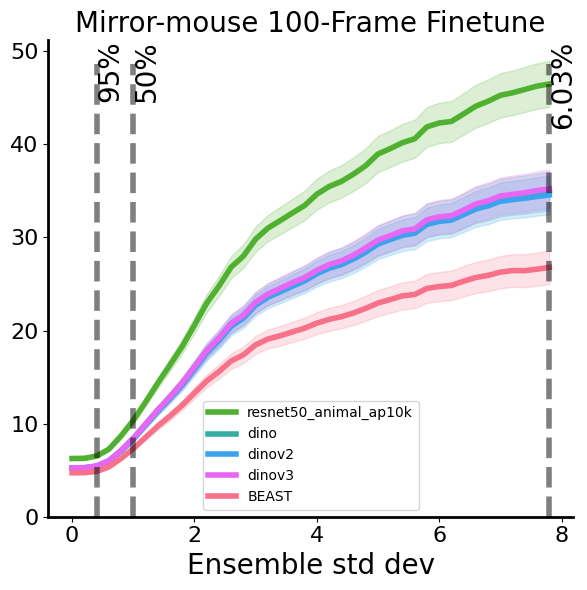

In [4]:
data_path = NEW_LITPOSE_SAVE_DIR / "mirror-mouse"
ens = Ensemble()
ens.data_to_plot = {
    # ----------------------
    # BEAST
    # ----------------------
    'BEAST.0': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse_mode-ft_model-vit_cm_frame-100_epoch-300_seed-0',
    'BEAST.1': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse_mode-ft_model-vit_cm_frame-100_epoch-300_seed-1',
    'BEAST.2': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse_mode-ft_model-vit_cm_frame-100_epoch-300_seed-2',
    # ----------------------
    # DINOV2
    # ----------------------
    'dinov2.0': f'{data_path}/ds-mirror-mouse_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-0',
    'dinov2.1': f'{data_path}/ds-mirror-mouse_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-1',
    'dinov2.2': f'{data_path}/ds-mirror-mouse_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # DINOV3
    # ----------------------
    'dinov3.0': f'{data_path}/ds-mirror-mouse_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-0',
    'dinov3.1': f'{data_path}/ds-mirror-mouse_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-1',
    'dinov3.2': f'{data_path}/ds-mirror-mouse_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # DINOV3
    # ----------------------
    'dino.0': f'{data_path}/ds-mirror-mouse_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-0',
    'dino.1': f'{data_path}/ds-mirror-mouse_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-1',
    'dino.2': f'{data_path}/ds-mirror-mouse_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # resnet50_animal_ap10k
    # ----------------------
    'resnet50_animal_ap10k.0': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-0',
    'resnet50_animal_ap10k.1': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-1',
    'resnet50_animal_ap10k.2': f'{LITPOSE_SAVE_DIR}/ds-mirror-mouse_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-2',
}
for key, val in ens.data_to_plot.items():
    ens.data_to_plot[key] = os.path.join(val, 'predictions_new.csv')

build_ensemble(ens)      

models_to_plot = [
    'resnet50_animal_ap10k',
    'dino',
    'dinov2',
    'dinov3',
    'BEAST',
]

def major_model(row_data):
    return '.'.join(row_data.split('.')[:-1])
ens.df_line2['model2'] = ens.df_line2['model'].apply(major_model)

df_line2 = ens.df_line2
n_points_dict = ens.n_points_dict
std_vals = ens.std_vals

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))

for model in models_to_plot:
    data = df_line2[df_line2['model2'] == model]
    sns.lineplot(x='ens-std', y='pixel_error', data=data, label=model, 
                 color=color_mapping[model], ax=ax, errorbar='se', linewidth=line_width)

ax.set_title('Mirror-mouse 100-Frame Finetune', fontsize=title_fontsize)
# ax.set_ylabel('Pixel error', fontsize=labels_fontsize)
ax.set_xlabel('Ensemble std dev', fontsize=labels_fontsize)
ax.set_ylim(bottom=0)  # Ensure y-axis starts at 0
ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

# Customize legend
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
# Turn off legend
ax.set_ylabel('')
# Plot annotations
percentiles = [95, 50, 5]
vals, prctiles = compute_percentiles(
    arr=n_points_dict[models_to_plot[0] + '.0'],
    std_vals=std_vals,
    percentiles=percentiles,
)

for p, v in zip(prctiles, vals):
    ax.axvline(v, ymax=0.95, linestyle='--', linewidth=line_width, color='black', alpha=0.5)
    ax.text(v, ax.get_ylim()[1], f'{p}%', ha='left', va='top', fontsize=labels_fontsize, rotation=90)

# set spines width
for spine in ax.spines.values():
    spine.set_linewidth(spines_width)

# set right and top spines invisible
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
# plt.grid(True, alpha=0.3)
plt.show()


IBL-Paw

No NaN values detected in preds array.
Total pixel error for model dino.0: 16877.49229924207
Total pixel error for model dino.1: 14310.537162038589
Total pixel error for model dino.2: 14984.04416571498
Total pixel error for model dinov2.0: 15650.643431798919
Total pixel error for model dinov2.1: 14111.477453999814
Total pixel error for model dinov2.2: 13217.431449404387
Total pixel error for model dinov3.0: 16127.72890971761
Total pixel error for model dinov3.1: 13626.351732530862
Total pixel error for model dinov3.2: 13958.891433869514
Total pixel error for model BEAST.0: 12181.530118762646
Total pixel error for model BEAST.1: 12228.532431679601
Total pixel error for model BEAST.2: 10464.949603131736
Total pixel error for model resnet50_animal_ap10k.0: 21178.161950307778
Total pixel error for model resnet50_animal_ap10k.1: 13903.669024789851
Total pixel error for model resnet50_animal_ap10k.2: 15682.56542929835


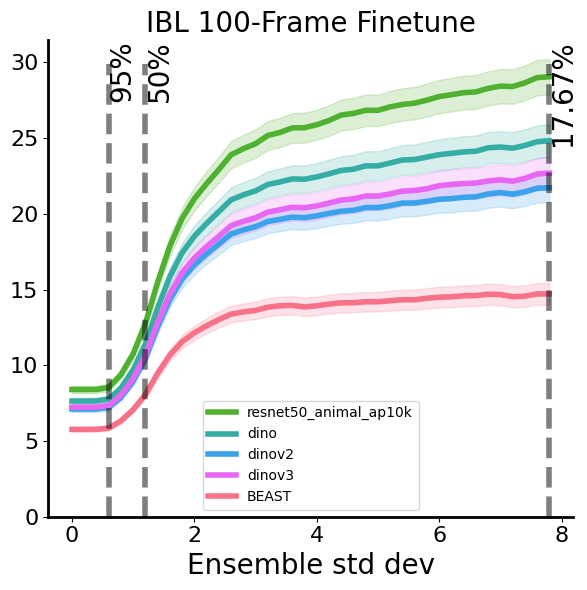

In [5]:
data_path = NEW_LITPOSE_SAVE_DIR / "ibl-paw"
ens = Ensemble()
ens.data_to_plot = {
     # ----------------------
    # DINOV
    # ----------------------
    'dino.0': f'{data_path}/ds-ibl-paw_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-0',
    'dino.1': f'{data_path}/ds-ibl-paw_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-1',
    'dino.2': f'{data_path}/ds-ibl-paw_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # DINOV2
    # ----------------------
    'dinov2.0': f'{data_path}/ds-ibl-paw_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-0',
    'dinov2.1': f'{data_path}/ds-ibl-paw_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-1',
    'dinov2.2': f'{data_path}/ds-ibl-paw_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # DINOV3
    # ----------------------
    'dinov3.0': f'{data_path}/ds-ibl-paw_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-0',
    'dinov3.1': f'{data_path}/ds-ibl-paw_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-1',
    'dinov3.2': f'{data_path}/ds-ibl-paw_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # vit_cm
    # ----------------------
    'BEAST.0': f'{LITPOSE_SAVE_DIR}/ds-ibl-paw_mode-ft_model-vit_cm_frame-100_epoch-300_seed-0',
    'BEAST.1': f'{LITPOSE_SAVE_DIR}/ds-ibl-paw_mode-ft_model-vit_cm_frame-100_epoch-300_seed-1',
    'BEAST.2': f'{LITPOSE_SAVE_DIR}/ds-ibl-paw_mode-ft_model-vit_cm_frame-100_epoch-300_seed-2',
    # --------------------------
    # resnet50_animal_ap10k
    # --------------------------
    'resnet50_animal_ap10k.0': f'{LITPOSE_SAVE_DIR}/ds-ibl-paw_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-0',
    'resnet50_animal_ap10k.1': f'{LITPOSE_SAVE_DIR}/ds-ibl-paw_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-1',
    'resnet50_animal_ap10k.2': f'{LITPOSE_SAVE_DIR}/ds-ibl-paw_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-2',
}

for key, val in ens.data_to_plot.items():
    ens.data_to_plot[key] = os.path.join(val, 'predictions_new.csv')

build_ensemble(ens)

models_to_plot = [
    'resnet50_animal_ap10k',
    'dino',
    'dinov2',
    'dinov3',
    'BEAST',
]

def major_model(row_data):
    return '.'.join(row_data.split('.')[:-1])
ens.df_line2['model2'] = ens.df_line2['model'].apply(major_model)

#models_to_plot = list(ens.data_to_plot.keys())
df_line2 = ens.df_line2
n_points_dict = ens.n_points_dict
std_vals = ens.std_vals

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))

for model in models_to_plot:
    data = df_line2[df_line2['model2'] == model]
    sns.lineplot(x='ens-std', y='pixel_error', data=data, label=model, 
                 color=color_mapping[model], ax=ax, errorbar='se', linewidth=line_width)

ax.set_title('IBL 100-Frame Finetune', fontsize=title_fontsize)
# ax.set_ylabel('Pixel error', fontsize=labels_fontsize)
ax.set_xlabel('Ensemble std dev', fontsize=labels_fontsize)
ax.set_ylim(bottom=0)  # Ensure y-axis starts at 0
ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

# Customize legend
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
# Turn off legend
# ax.legend().remove()
# remove y-axis label
ax.set_ylabel('')

# Plot annotations
percentiles = [95, 50, 5]
vals, prctiles = compute_percentiles(
    arr=n_points_dict[models_to_plot[0] + '.0'],
    std_vals=std_vals,
    percentiles=percentiles,
)

for p, v in zip(prctiles, vals):
    ax.axvline(v, ymax=0.95, linestyle='--', linewidth=line_width, color='black', alpha=0.5)
    ax.text(v, ax.get_ylim()[1], f'{p}%', ha='left', va='top', fontsize=labels_fontsize, rotation=90)

# set spines width
for spine in ax.spines.values():
    spine.set_linewidth(spines_width)

# set right and top spines invisible
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
# plt.grid(True, alpha=0.3)
plt.show()



CRIM13

No NaN values detected in preds array.
Total pixel error for model dino.0: 346436.1598708205
Total pixel error for model dino.1: 328966.461736381
Total pixel error for model dino.2: 399851.8382129751
Total pixel error for model dinov2.0: 346337.719008632
Total pixel error for model dinov2.1: 338479.32804790104
Total pixel error for model dinov2.2: 341428.86269954336
Total pixel error for model dinov3.0: 333173.66210805083
Total pixel error for model dinov3.1: 343116.19079518586
Total pixel error for model dinov3.2: 355368.6179793876
Total pixel error for model BEAST.0: 283266.624347585
Total pixel error for model BEAST.1: 281921.2081603309
Total pixel error for model BEAST.2: 292268.5133240215
Total pixel error for model resnet50_animal_ap10k.0: 381576.69264890335
Total pixel error for model resnet50_animal_ap10k.1: 400680.08066543686
Total pixel error for model resnet50_animal_ap10k.2: 380166.0648170031


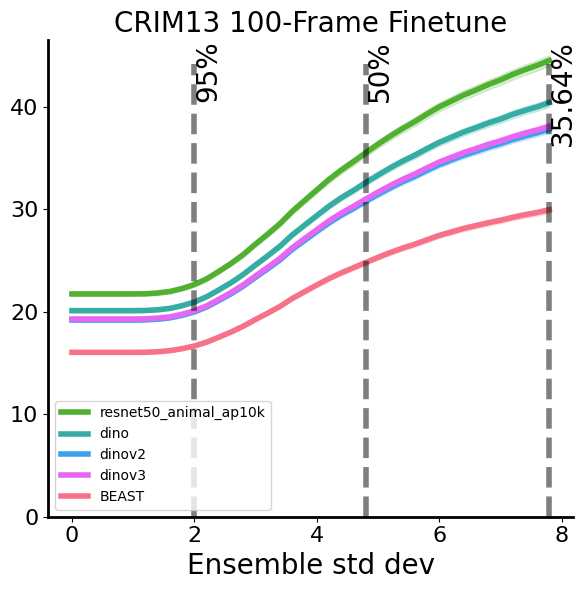

In [6]:
data_path = NEW_LITPOSE_SAVE_DIR / "crim13"
ens = Ensemble()
ens.data_to_plot = {
    # ----------------------
    # DINO  
    # ----------------------
    'dino.0': f'{data_path}/ds-crim13_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-0',
    'dino.1': f'{data_path}/ds-crim13_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-1',
    'dino.2': f'{data_path}/ds-crim13_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # DINOV2
    # ----------------------
    'dinov2.0': f'{data_path}/ds-crim13_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-0',
    'dinov2.1': f'{data_path}/ds-crim13_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-1',
    'dinov2.2': f'{data_path}/ds-crim13_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # DINOV3
    # ----------------------
    'dinov3.0': f'{data_path}/ds-crim13_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-0',
    'dinov3.1': f'{data_path}/ds-crim13_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-1',
    'dinov3.2': f'{data_path}/ds-crim13_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # BEAST
    # ----------------------
    'BEAST.0': f'{LITPOSE_SAVE_DIR}/ds-crim13_mode-ft_model-vit_cm_frame-100_epoch-300_seed-0',
    'BEAST.1': f'{LITPOSE_SAVE_DIR}/ds-crim13_mode-ft_model-vit_cm_frame-100_epoch-300_seed-1',
    'BEAST.2': f'{LITPOSE_SAVE_DIR}/ds-crim13_mode-ft_model-vit_cm_frame-100_epoch-300_seed-2',
    # ----------------------
    # resnet50_animal_ap10k
    # ----------------------
    'resnet50_animal_ap10k.0': f'{LITPOSE_SAVE_DIR}/ds-crim13_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-0',
    'resnet50_animal_ap10k.1': f'{LITPOSE_SAVE_DIR}/ds-crim13_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-1',
    'resnet50_animal_ap10k.2': f'{LITPOSE_SAVE_DIR}/ds-crim13_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-2',
}
for key, val in ens.data_to_plot.items():
    ens.data_to_plot[key] = os.path.join(val, 'predictions_new.csv')

build_ensemble(ens)      

models_to_plot = [
    'resnet50_animal_ap10k',
    'dino',
    'dinov2',
    'dinov3',
    'BEAST',
]

def major_model(row_data):
    return '.'.join(row_data.split('.')[:-1])
ens.df_line2['model2'] = ens.df_line2['model'].apply(major_model)

df_line2 = ens.df_line2
n_points_dict = ens.n_points_dict
std_vals = ens.std_vals

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))

for model in models_to_plot:
    data = df_line2[df_line2['model2'] == model]
    sns.lineplot(x='ens-std', y='pixel_error', data=data, label=model, 
                 color=color_mapping[model], ax=ax, errorbar='se', linewidth=line_width)

ax.set_title('CRIM13 100-Frame Finetune', fontsize=title_fontsize)
# ax.set_ylabel('Pixel error', fontsize=labels_fontsize)
ax.set_xlabel('Ensemble std dev', fontsize=labels_fontsize)
ax.set_ylim(bottom=0)  # Ensure y-axis starts at 0
ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

# Customize legend
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
# Turn off legend
# ax.legend().remove()
ax.set_ylabel('')
# Plot annotations
percentiles = [95, 50, 5]
vals, prctiles = compute_percentiles(
    arr=n_points_dict[models_to_plot[0] + '.0'],
    std_vals=std_vals,
    percentiles=percentiles,
)

for p, v in zip(prctiles, vals):
    ax.axvline(v, ymax=0.95, linestyle='--', linewidth=line_width, color='black', alpha=0.5)
    ax.text(v, ax.get_ylim()[1], f'{p}%', ha='left', va='top', fontsize=labels_fontsize, rotation=90)

# set spines width
for spine in ax.spines.values():
    spine.set_linewidth(spines_width)

# set right and top spines invisible
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
# plt.grid(True, alpha=0.3)
plt.show()


Mirror-Fish

No NaN values detected in preds array.
Total pixel error for model dino.0: 27352.40212725982
Total pixel error for model dino.1: 29400.770415792354
Total pixel error for model dino.2: 27558.368159691596
Total pixel error for model dinov3.0: 27209.748389690787
Total pixel error for model dinov3.1: 30819.376793184536
Total pixel error for model dinov3.2: 27592.80363595893
Total pixel error for model dinov2.0: 28107.469250134
Total pixel error for model dinov2.1: 30143.240655883637
Total pixel error for model dinov2.2: 27288.992104295157
Total pixel error for model BEAST.0: 26548.64816870555
Total pixel error for model BEAST.1: 27050.57126074806
Total pixel error for model BEAST.2: 26418.927971522386
Total pixel error for model resnet50_animal_ap10k.0: 39063.4697782329
Total pixel error for model resnet50_animal_ap10k.1: 40344.092944834956
Total pixel error for model resnet50_animal_ap10k.2: 33945.948596587616


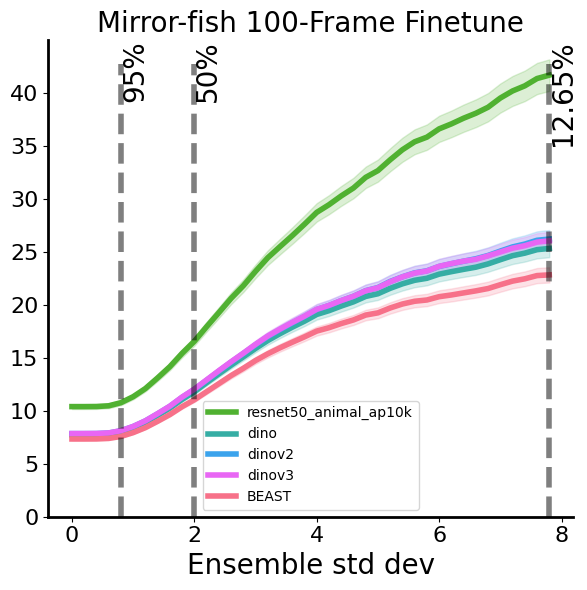

In [7]:
data_path = NEW_LITPOSE_SAVE_DIR / "mirror-fish"

ens = Ensemble()
ens.data_to_plot = {
    # ----------------------
    # DINO
    # ----------------------
    'dino.0': f'{data_path}/ds-mirror-fish_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-0',
    'dino.1': f'{data_path}/ds-mirror-fish_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-1',
    'dino.2': f'{data_path}/ds-mirror-fish_mode-ft_model-vitb_dino_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # DINOV3
    # ----------------------
    'dinov3.0': f'{data_path}/ds-mirror-fish_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-0',
    'dinov3.1': f'{data_path}/ds-mirror-fish_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-1',
    'dinov3.2': f'{data_path}/ds-mirror-fish_mode-ft_model-vitb_dinov3_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # DINOV2
    # ----------------------
    'dinov2.0': f'{data_path}/ds-mirror-fish_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-0',
    'dinov2.1': f'{data_path}/ds-mirror-fish_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-1',
    'dinov2.2': f'{data_path}/ds-mirror-fish_mode-ft_model-vitb_dinov2_type-heatmap_frame-100_epoch-300_seed-2',
    # ----------------------
    # BEAST
    # ----------------------
    'BEAST.0': f'{LITPOSE_SAVE_DIR}/ds-mirror-fish_mode-ft_model-vit_cm_frame-100_epoch-300_seed-0',
    'BEAST.1': f'{LITPOSE_SAVE_DIR}/ds-mirror-fish_mode-ft_model-vit_cm_frame-100_epoch-300_seed-1',
    'BEAST.2': f'{LITPOSE_SAVE_DIR}/ds-mirror-fish_mode-ft_model-vit_cm_frame-100_epoch-300_seed-2',
    # ----------------------
    # resnet50_animal_ap10k
    # ----------------------
    'resnet50_animal_ap10k.0': f'{LITPOSE_SAVE_DIR}/ds-mirror-fish_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-0',
    'resnet50_animal_ap10k.1': f'{LITPOSE_SAVE_DIR}/ds-mirror-fish_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-1',
    'resnet50_animal_ap10k.2': f'{LITPOSE_SAVE_DIR}/ds-mirror-fish_mode-ft_model-resnet50_animal_ap10k_frame-100_epoch-300_seed-2',
}
for key, val in ens.data_to_plot.items():
    ens.data_to_plot[key] = os.path.join(val, 'predictions_new.csv')

build_ensemble(ens)      

models_to_plot = [
    'resnet50_animal_ap10k',
    'dino',
    'dinov2',
    'dinov3',
    'BEAST',
]

def major_model(row_data):
    return '.'.join(row_data.split('.')[:-1])
ens.df_line2['model2'] = ens.df_line2['model'].apply(major_model)

df_line2 = ens.df_line2
n_points_dict = ens.n_points_dict
std_vals = ens.std_vals

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))

for model in models_to_plot:
    data = df_line2[df_line2['model2'] == model]
    sns.lineplot(x='ens-std', y='pixel_error', data=data, label=model, 
                 color=color_mapping[model], ax=ax, errorbar='se', linewidth=line_width)

ax.set_title('Mirror-fish 100-Frame Finetune', fontsize=title_fontsize)
# ax.set_ylabel('Pixel error', fontsize=labels_fontsize)
ax.set_xlabel('Ensemble std dev', fontsize=labels_fontsize)
ax.set_ylim(bottom=0)  # Ensure y-axis starts at 0
ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

# Customize legend
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
# Turn off legend
# ax.legend().remove()
ax.set_ylabel('')
# Plot annotations
percentiles = [95, 50, 5]
vals, prctiles = compute_percentiles(
    arr=n_points_dict[models_to_plot[0] + '.0'],
    std_vals=std_vals,
    percentiles=percentiles,
)

for p, v in zip(prctiles, vals):
    ax.axvline(v, ymax=0.95, linestyle='--', linewidth=line_width, color='black', alpha=0.5)
    ax.text(v, ax.get_ylim()[1], f'{p}%', ha='left', va='top', fontsize=labels_fontsize, rotation=90)

# set spines width
for spine in ax.spines.values():
    spine.set_linewidth(spines_width)

# set right and top spines invisible
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
# plt.grid(True, alpha=0.3)
plt.show()
